In [239]:
#importing some useful packages
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

#class for averaging both locally (between line pieces) and globally (between images)
class line_stats:
    def __init__(self, new_weight=1, max_weight=10):
        self.x = 0
        self.y = 0
        self.slope = 0
        self.weight = 0
        self.new_weight = new_weight
        self.max_weight = max_weight

    def add(self, x, y, slope):
        self.x = (self.weight * self.x + self.new_weight * x) / (self.weight + self.new_weight)
        self.y = (self.weight * self.y + self.new_weight * y) / (self.weight + self.new_weight)
        self.slope = (self.weight * self.slope + self.new_weight * slope) / (self.weight + self.new_weight)
        if self.weight<self.max_weight:
          self.weight+=self.new_weight

#class for detecting line lanes        
class line_detector:    
    def __init__(self):
        #storing the global statistics as well as the vertices for both lanes
        self.lanes = [line_stats() for _ in range(2)]
        self.vertices = np.array([])
        #camera calibration parameters
        self.mtx = []
        self.dist = []
        #warp matrix
        self.M = []
        
    def grayscale(self, image):
        """Applies the Grayscale transform
        This will return an image with only one color channel
        but NOTE: to see the returned image as grayscale
        (assuming your grayscaled image is called 'gray')
        you should call plt.imshow(gray, cmap='gray')"""
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    def calibrate_camera(self, images_list, size):
        objpoints = []
        imgpoints = []
        objp = np.zeros((size[1]*size[0],3), np.float32)
        objp[:,:2] = np.mgrid[0:size[0], 0:size[1]].T.reshape(-1,2)
        for fname in images:
            img = mpimg.imread(fname)
            gray = self.grayscale(img)
            ret, corners = cv2.findChessboardCorners(gray, (size[0],size[1]), None)
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)      
                
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        return ret
    
    def undistort(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        
    def calibrate_perspective(self, image, size, offset):
        gray = self.grayscale(image)
        ret, corners = cv2.findChessboardCorners(gray, (size[0],size[1]), None)
    
        if ret == True:
            #cv2.drawChessboardCorners(dest, (size[0],size[1]), corners, ret)
        
            src = np.float32([corners[0], corners[size[0]-1], corners[-1], corners[-size[0]]])
            dst = np.float32([[offset, offset], [image.shape[1]-offset, offset], [image.shape[1]-offset, image.shape[0]-offset], [offset, image.shape[0]-offset]])

            self.M = cv2.getPerspectiveTransform(src, dst)
        
    def get_warp(self, image, offset):
        src = self.vertices.astype(np.float32)
        #np.float32([self.vertices[0], self.vertices[1], self.vertices[2], self.vertices[3]]) 
        ox = offset[0]
        oy = offset[1]
        dst = np.float32([[ox, oy], [image.shape[1]-ox, oy], [image.shape[1]-ox, image.shape[0]-oy], [ox, image.shape[0]-oy]])
        self.M = cv2.getPerspectiveTransform(src, dst)
        
    def warp_image(self, image):
        #gray = self.grayscale(image)
        #return cv2.warpPerspective(gray, self.M, gray.shape[::-1])
        return cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]))
    
    def unwarp_image(self, image):
        #gray = self.grayscale(image)
        #return cv2.warpPerspective(gray, self.M, gray.shape[::-1])
        return cv2.warpPerspective(image, np.linalg.inv(self.M), (image.shape[1], image.shape[0]))
    
    def treshold_image(self, image, s_thresh=(170, 255), sx_thresh=(30, 100), sobel_kernel=15):
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1      
        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        # Stack each channel
        #return combined_binary          
        return combined_binary
                  
    def find_lane(self, warped, nwindows = 9, margin = 150, minpix = 50):
        #nwindows: number of sliding windows
        #margin: margin from the left and right side of the warped image
        #minpix: minimum number of pixels found to recenter window
        
        histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((warped, warped, warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
        # Set height of windows
        window_height = np.int(warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        #plt.imshow(out_img)
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*warped.shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*warped.shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        radius = (left_curverad+right_curverad)/2

        center = warped.shape[1]/2
        pl = left_fitx[warped.shape[0]-1]
        pr = right_fitx[warped.shape[0]-1]

        position = xm_per_pix*((pl+pr)/2-center)
        
        area = np.zeros_like(warped)
        for y in range(warped.shape[0]):
            for x in range(int(left_fitx[y]), int(right_fitx[y])):
                area[y][x] = 1
                
        return (radius, position, area)

        
    def canny(self, img, low_threshold, high_threshold):
        """Applies the Canny transform"""
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(self, img, kernel_size):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(self, img):
        """
        Applies an image mask.
        
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   
    
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, self.vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image


    def draw_lines(self, img, lines, y_limit, color=[255, 0, 0], thickness=10):
        act_lanes = [line_stats(1, 100) for _ in range(2)] #for averaging local pieces
        y_size = img.shape[1]
            
        for line in lines:
          for x1,y1,x2,y2 in line:
            slope = (x2-x1)/(y2-y1)
            if abs(slope)>2: #discarding line pieces with >=45 degrees of slope (and the inf values in case div by z)                
                continue
            if slope<0:      #updating local lane stats               
                act_lanes[0].add((x1+x2)/2, (y1+y2)/2, slope)
            else: 
                act_lanes[1].add((x1+x2)/2, (y1+y2)/2, slope)
                
        for i in range(2):
            pic_lane = act_lanes[i]
            global_lane = self.lanes[i]            
            if pic_lane.weight>0:  #updating global lane stats
               global_lane.add(pic_lane.x, pic_lane.y, pic_lane.slope)
            x1 = int(global_lane.x+(y_size-global_lane.y)*global_lane.slope)
            x2 = int(global_lane.x+(y_limit-global_lane.y)*global_lane.slope)
            cv2.line(img, (x1, y_size), (x2, y_limit), color, thickness)       

    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap, y_limit):
        """
        `img` should be the output of a Canny transform.
            
        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self.draw_lines(line_img, lines, y_limit)
        return line_img

    def weighted_img(self, img, initial_img, α=0.8, β=1., λ=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.
    
        `initial_img` should be the image before any processing.
    
        The result image is computed as follows:
    
        initial_img * α + img * β + λ
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)
    
    def set_roi(self, p1, p2, p3, p4):
        self.vertices = np.array([[p1, p2, p3, p4]], dtype=np.int32)
    
    def process_image(self, image):
        # NOTE: The output you return should be a color image (3 channel) for processing video below
        # TODO: put your pipeline here,
        # you should return the final output (image where lines are drawn on lanes)
        img_gray  = self.grayscale(image)
        img_blur  = self.gaussian_blur(img_gray, 5)
        img_canny = self.canny(img_blur, 10, 250)
        
        #this does not really belong here but this way it works with both video sizes without updating anything
        if not self.vertices.any():
          if image.shape[0]==540:
            self.set_roi((0, 540), (450, 320), (520, 320), (900, 540))
          else: 
            self.set_roi((200, 660), (600, 450), (780, 450), (1100, 660))
        
        img_roi = self.region_of_interest(img_canny)
        img_hough = self.hough_lines(img_roi, 2, np.pi/180, 25, 30, 30, self.vertices[0][1][1])
        result = self.weighted_img(img_hough, image)        
        
        return result

def detect_lane_lines(input_clip, output_clip):   
    test_clip = VideoFileClip(input_clip)
    detector = line_detector()
    new_clip = test_clip.fl_image( detector.process_image )
    %time new_clip.write_videofile(output_clip, audio=False)

In [240]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

images = glob.glob("camera_cal/calibration*.jpg")
cal_img = mpimg.imread("camera_cal/calibration2.jpg")
test_img = mpimg.imread("test_images/straight_lines1.jpg")

detector = line_detector()
detector.calibrate_camera(images, (9,6))

"""
dst = detector.undistort(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

"\ndst = detector.undistort(test_img)\n\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(test_img)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(dst)\nax2.set_title('Undistorted Image', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [241]:
"""
detector.calibrate_perspective(cal_img, (9,6), 100)

undistorted = detector.undistort(cal_img)
warped = detector.warp_image(undistorted)

plt.imshow(warped)
"""

'\ndetector.calibrate_perspective(cal_img, (9,6), 100)\n\nundistorted = detector.undistort(cal_img)\nwarped = detector.warp_image(undistorted)\n\nplt.imshow(warped)\n'

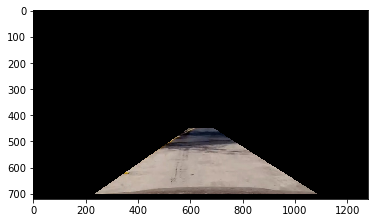

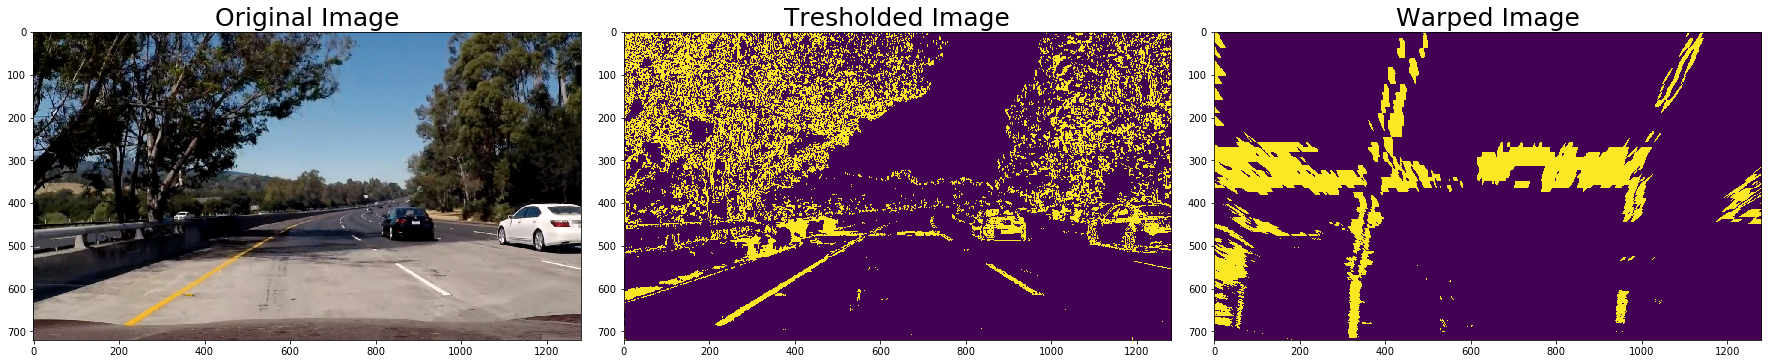

In [242]:
%matplotlib inline

test_img = mpimg.imread("test_images/test5.jpg")

detector.set_roi((595,450), (689, 450), (1085, 700), (235, 700))
#detector.set_roi((590,450), (730, 450), (1130, 700), (230, 700))
undistorted = detector.undistort(test_img)
masked = detector.region_of_interest(undistorted)
plt.imshow(masked)

detector.get_warp(test_img, (350, 0))

undistorted = detector.undistort(test_img)
tresholded = detector.treshold_image(test_img, (130,255), (25,100), 5)
warped = detector.warp_image(tresholded)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(tresholded)
ax2.set_title('Tresholded Image', fontsize=25)
ax3.imshow(warped)
ax3.set_title('Warped Image', fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

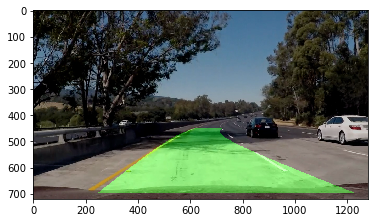

In [243]:
(radius, position, lane) = detector.find_lane(warped)
#plt.imshow(detector.unwarp_image(lane))

area = np.zeros_like(test_img)
area[:,:,1] = detector.unwarp_image(lane)*255

result = detector.weighted_img(area, test_img, α=0.8, β=0.4, λ=0.)

plt.imshow(result)

In [2]:
#input = "test_videos/solidWhiteRight.mp4"
#input = "test_videos/solidYellowLeft.mp4"
#input = "test_videos/challenge.mp4"
input = "project_video.mp4"
output = "test_output.mp4"

detect_lane_lines(input, output)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [00:29<00:00, 43.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

Wall time: 29.9 s


In [3]:
HTML("""
<video width="640" height="300" controls>
  <source src={0} type="video/mp4">
</video>
""".format(output))